In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import gc
import re
import lightgbm as lgb
from datetime import datetime
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from geohash import encode
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from multiprocessing import Pool

%config InlineBackend.figure_format = 'retina' # set 'png' here when working on notebook
%matplotlib inline

# 新房数据表路径
newdisk_path='../../数据/AD_NewDisk.csv'
# 房源属性数据表路径
property_path='../../数据/AD_Property.csv'
# 地址数据表路径
address_path='../../数据/AD_NewDiskAddress.csv'
# 训练集起始月份
beginDate='2017-05'
# 训练集终止月份
endDate='2018-04'

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## 加载数据

In [2]:
data_path='/Users/wangdexun/Documents/gubbins/房价大数据/数据/挂牌数据/'

def load_data(name,month):
    # 读取挂牌数据
    with open(os.path.join(data_path,name,'挂牌.txt')) as f:
        l=[]
        for i in f.readlines():
            l.append(i.split('\t'))
        df=pd.DataFrame(l)
        drop_col=[0,15,16,18,19,20,21]
        if len(df.columns)==23:
            drop_col.append(22)
        df.drop(drop_col,axis=1,inplace=True) # 去除无用列
        df.columns=['area','address','name','price','unit_price','acreage','room_type','all_floor','floor','shore','house_type','fitment','time','Source','house_trait']
        df['month']=month
        return df

pool=Pool()
# files=[i for i in os.listdir(data_path) if '.' not in i]
files=np.unique([datetime.strftime(x,'%Y-%m') for x in list(pd.date_range(start=beginDate, end=endDate))])
files=sorted(files)
dfs=[pool.apply_async(load_data,(name,month)) for month,name in enumerate(files)]
pool.close()
pool.join()
dfs=[i.get() for i in dfs]

In [3]:
print(len(dfs))
all_df=pd.concat(dfs,ignore_index=True)

12


In [2]:
# 获取经纬度信息
newdisk_df=pd.read_csv(newdisk_path,\
                       usecols=['NewDiskID','PropertyID','NewDiskName','Coordinates'])
newdisk_df.rename(columns={'NewDiskName':'name'},inplace=True)
# newdisk_df.dropna(inplace=True)
# newdisk_df.drop_duplicates('PropertyID',inplace=True)
print(newdisk_df.shape)
newdisk_df.head()

(17861, 4)


,NewDiskID,PropertyID,name,Coordinates
0,1,14578,海伦国际大厦,"121.48593904918,31.268556126592"
1,2,14583,和源大楼,"121.47417360118,31.271112531812"
2,3,14584,财富中心,"121.46979487834,31.259056541178"
3,4,14602,科创动力,"121.42412471181,31.181237621707"
4,5,14613,绿地伯顿商务广场,"121.25327636955,31.022714501392"


In [3]:
# 获取板块、环线信息
property_df=pd.read_csv(property_path,\
                        usecols=['PropertyID','Area','Plate','Module','HousingName'])
property_df.rename(columns={'Area':'area','HousingName':'name'},inplace=True)
print(property_df.shape)
property_df.head()

(15707, 5)


,PropertyID,area,Plate,Module,name
0,1,嘉定,安亭汽车城,外郊环,澳丽映象嘉园
1,2,普陀,武宁,内环内,浅水湾恺悦名城
2,3,徐汇,徐汇中心,内环内,青松小区
3,4,浦东,洋泾,内环内,巨洋小区
4,5,金山,石化,外郊环,海趣馨苑


In [4]:
# 获取楼盘地址信息
address_df=pd.read_csv(address_path,usecols=['RoadLaneNo','NewDiskID'])
address_df.rename(columns={'RoadLaneNo':'address'},inplace=True)
# address_df.address=address_df.address.apply(lambda x:x.split('路')[0]+'路')
# address_df.drop_duplicates(['NewDiskID'],inplace=True)
print(address_df.shape)
address_df.head()

(163269, 2)


,address,NewDiskID
0,宝山路800号,1
1,宝山路778号,1
2,平型关路38号,2
3,共和新路566号,3
4,宜山路700号,4


In [5]:
# merge them
meta_df=pd.merge(newdisk_df,property_df.drop('name',axis=1),on='PropertyID',how='left')
# meta_df=pd.merge(meta_df,address_df,on='NewDiskID',how='left')
print(meta_df.shape)
meta_df.head()

(17861, 7)


,NewDiskID,PropertyID,name,Coordinates,area,Plate,Module
0,1,14578,海伦国际大厦,"121.48593904918,31.268556126592",虹口,四川北路,内环内
1,2,14583,和源大楼,"121.47417360118,31.271112531812",静安,大宁,内中环
2,3,14584,财富中心,"121.46979487834,31.259056541178",静安,不夜城,内环内
3,4,14602,科创动力,"121.42412471181,31.181237621707",徐汇,田林,内中环
4,5,14613,绿地伯顿商务广场,"121.25327636955,31.022714501392",松江,松江新城,外郊环


In [2]:
all_df=pd.read_hdf('./cache/guapai_%s-%s.hdf'%(beginDate,endDate),'data')
print(all_df.shape)
all_df.head()

(5616994, 20)


,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,house_type,fitment,time,Source,house_trait,month,NewDiskID,Coordinates,Plate,Module
0,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,12815,"121.53567016,31.190760657274",北蔡,中外环
1,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,14262,"121.54894320781,31.183898514602",北蔡,内中环
2,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,14307,"121.51561005474,31.178421520944",北蔡,内中环
3,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,14579,"121.53970979497,31.188601497767",北蔡,内中环
4,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,15073,"121.51561005474,31.178421520944",北蔡,内中环


In [61]:
# 小区名正则过滤
def name_filter(name):
    n=re.compile('\(|\（|一期|二期').split(name)[0]
    n=re.sub(r'\(.*?\)', '', re.sub(r'\（.*?\）', '', n))
    n=n.strip('*0123456789(（）)')
    n=n.split('第')[0]
    return n

# 小区名称清洗
index=meta_df.name.notnull()
meta_df.loc[index,'name']=meta_df.loc[index,'name'].apply(name_filter)
all_df.name=all_df.name.apply(name_filter)

In [62]:
# 小区地址清洗
def address_filter(address):
    n=re.compile(',|，|、').split(address)[0]
    n=re.sub(r'\(.*?\)', '', re.sub(r'\（.*?\）', '', n))
    n=n.strip('*0123456789')
    return n

address_df.address=address_df.address.apply(address_filter)
all_df.address=all_df.address.apply(address_filter)

In [63]:
# 转换数值类型 str->float
numerical_columns=['price','unit_price','acreage','all_floor','floor']
all_df[numerical_columns]=all_df[numerical_columns].astype(float)
all_df[numerical_columns].describe()

,price,unit_price,acreage,all_floor,floor
count,5.616994e+06,5.616994e+06,5.616994e+06,5.616994e+06,5.616994e+06
mean,6.685706e+06,5.626228e+04,1.092098e+02,1.252719e+01,6.640646e+00
std,9.958919e+06,3.331713e+04,1.223642e+02,1.008268e+01,7.289373e+00
min,1.000000e+04,0.000000e+00,2.100000e+00,0.000000e+00,-5.000000e+00
25%,2.850000e+06,3.923100e+04,6.222000e+01,6.000000e+00,2.000000e+00
50%,4.150000e+06,5.306600e+04,8.835000e+01,7.000000e+00,4.000000e+00
75%,7.000000e+06,6.826900e+04,1.219800e+02,1.700000e+01,9.000000e+00
max,9.999900e+08,2.590648e+07,1.090890e+05,9.000000e+01,7.400000e+01


In [12]:
# # 变量间相关性
# sns.set({'figure.figsize':(8,8)})
# sns.heatmap(all_df.corr(),annot=True)

In [64]:
all_df['No']=range(all_df.shape[0])
address_match=pd.merge(all_df[['No','address']],address_df,on='address',how='inner')
name_match=pd.merge(all_df[['No','name','area']],meta_df[['name','area','NewDiskID']],on=['name','area'],how='inner')

In [65]:
match=pd.concat((address_match[['No','NewDiskID']],name_match[['No','NewDiskID']]),ignore_index=True)
match.drop_duplicates(keep='first',inplace=True)
match=match.sort_values('No')
match

,No,NewDiskID
0,0,12815
3450183,0,21390
3450182,0,16555
3450181,0,15073
3450180,0,14579
3450184,0,22033
3450178,0,14262
3450179,0,14307
1,1,12815
3450185,1,14262


In [66]:
all_df=all_df.loc[match.No]
all_df['NewDiskID']=match.NewDiskID.values
all_df.drop('No',axis=1,inplace=True)

In [67]:
all_df=pd.merge(all_df,meta_df[['NewDiskID','Coordinates','Plate','Module']],on='NewDiskID',how='left')

KeyboardInterrupt: 

In [17]:
all_df.to_hdf('./cache/guapai_%s-%s.hdf'%(beginDate,endDate),'data')
all_df.shape

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['area', 'address', 'name', 'room_type', 'shore', 'house_type', 'fitment', 'time', 'Source', 'house_trait', 'Coordinates', 'Plate', 'Module']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


(5616994, 20)

In [30]:
all_df.head()

,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,house_type,fitment,time,Source,house_trait,month,NewDiskID,Coordinates,Plate,Module
0,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,12815,"121.53567016,31.190760657274",北蔡,中外环
1,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,14262,"121.54894320781,31.183898514602",北蔡,内中环
2,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,14307,"121.51561005474,31.178421520944",北蔡,内中环
3,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,14579,"121.53970979497,31.188601497767",北蔡,内中环
4,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,公寓,精装修,2008-01-01,房天下,普通住宅,0,15073,"121.51561005474,31.178421520944",北蔡,内中环


## 特征预处理

* 修正面积

count    5.616994e+06
mean     1.092098e+02
std      1.223642e+02
min      2.100000e+00
25%      6.222000e+01
50%      8.835000e+01
75%      1.219800e+02
max      1.090890e+05
Name: acreage, dtype: float64


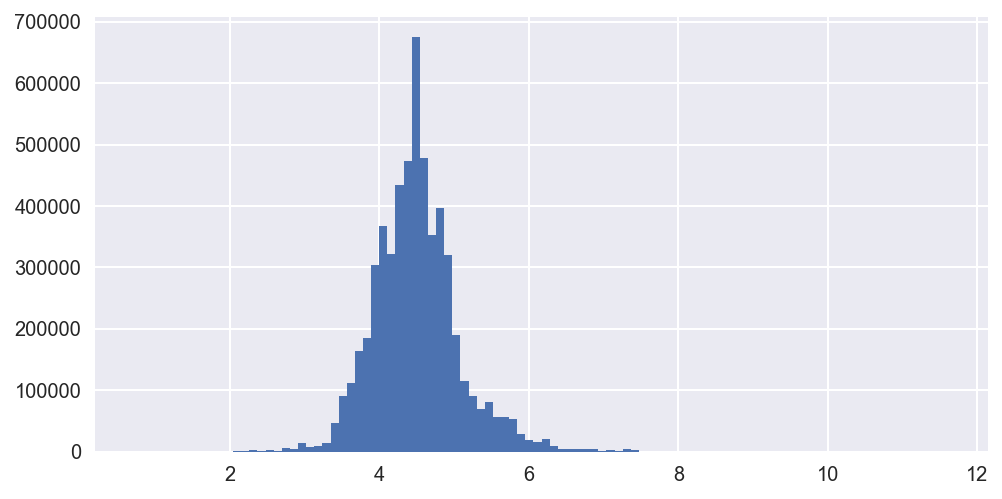

In [140]:
print(all_df.acreage.describe())
sns.set({'figure.figsize':(8,4)})
np.log(all_df.acreage).hist(bins=100) # log化处理偏态数据

In [141]:
# 计算偏度
print('修正前：%f'%skew(all_df.acreage))
print('修正后：%f'%skew(np.log(all_df.acreage)))

修正前：256.675821
修正后：0.660534


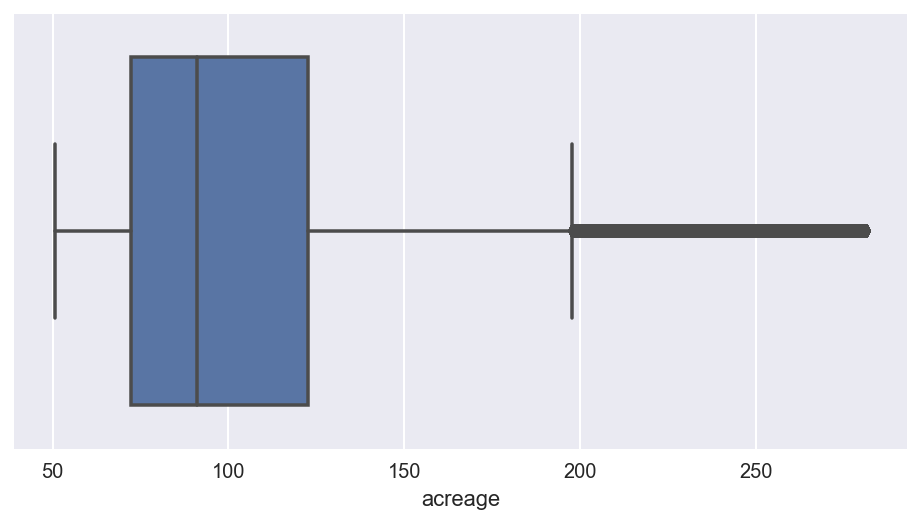

In [142]:
acreage_log=np.log(all_df.acreage)
mean=acreage_log.mean()
std=acreage_log.std()
i=acreage_log[(acreage_log<=mean+2*std)&(acreage_log>=mean-1*std)].index
sns.set({'figure.figsize':(8,4)})
sns.boxplot(all_df.loc[i].acreage)
all_df.loc[i].acreage.describe()

all_df=all_df.loc[i]

* 修正单价

count    4.631596e+06
mean     5.481336e+04
std      2.947667e+04
min      2.240000e+02
25%      3.852300e+04
50%      5.183600e+04
75%      6.702200e+04
max      1.923058e+07
Name: unit_price, dtype: float64


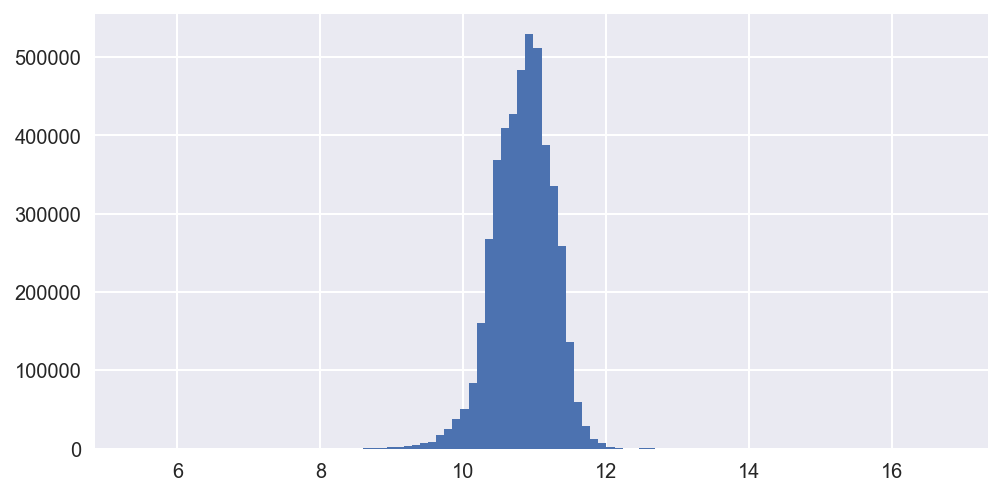

In [143]:
print(all_df.unit_price.describe())
np.log1p(all_df.unit_price).hist(bins=100)

In [144]:
# 计算偏度
print('修正前：%f'%skew(all_df.unit_price))
print('修正后：%f'%skew(np.log1p(all_df.unit_price)))

修正前：238.601080
修正后：-0.403022


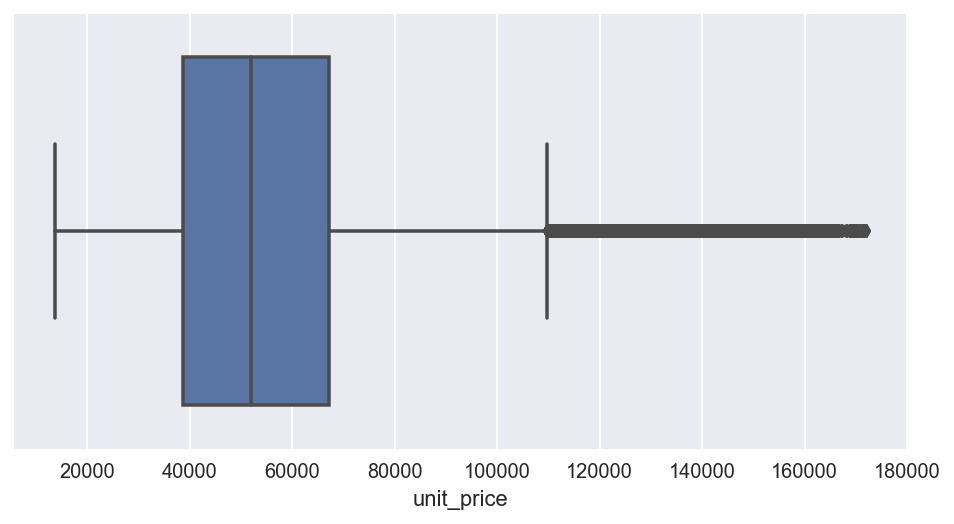

In [145]:
unit_price_log=np.log1p(all_df.unit_price)
mean=unit_price_log.mean()
std=unit_price_log.std()
i=unit_price_log[(unit_price_log<=mean+3*std)&(unit_price_log>=mean-3.2*std)].index
sns.set({'figure.figsize':(8,4)})
sns.boxplot(all_df.loc[i].unit_price)
all_df.loc[i].unit_price.describe()

all_df=all_df.loc[i]

* 修复总价

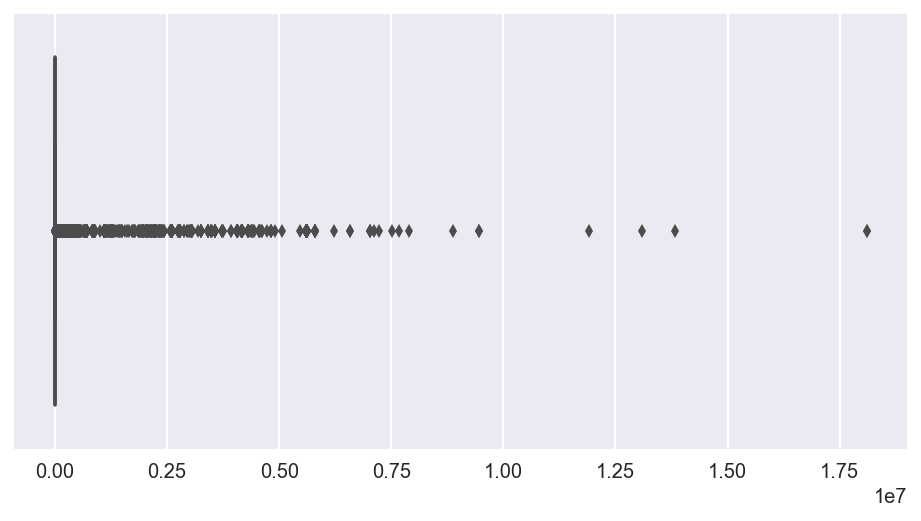

In [146]:
# 修复总价单位误差
all_df.loc[all_df.price<=10000,'price']*=10000

# 差价分布
anomaly_price=np.abs(all_df.unit_price*all_df.acreage-all_df.price)
sns.set({'figure.figsize':(8,4)})
sns.boxplot(anomaly_price)

In [147]:
anomaly_price_index=anomaly_price[anomaly_price>100000].index # 差价太多为异常点
anomaly_price[anomaly_price_index].sort_values()

# 修正异常的总价
# train.loc[anomaly_price_index,'price']=train.loc[anomaly_price_index,'unit_price']*train.loc[anomaly_price_index,'acreage']

# 直接删除异常样本
all_df.drop(anomaly_price_index,axis=0,inplace=True)

In [148]:
# 修复后，差价都在合理范围内?
np.abs(all_df.unit_price*all_df.acreage-all_df.price).sort_values(ascending=False)[:10]

4231535    100000.00
4231534    100000.00
4118330    100000.00
4204056     99705.80
3571122     99507.50
3863942     99507.50
4171710     99112.00
3823869     99112.00
4144336     98994.39
5345749     98387.70
dtype: float64

* 地区因素

In [149]:
# 各地区的均价
all_df[['unit_price','area']].groupby('area').mean().sort_values('unit_price')

,unit_price
area,
金山,20638.624213
崇明,21873.151123
奉贤,30668.790135
青浦,32484.969150
嘉定,36387.627956
松江,36607.403112
宝山,44917.853776
闵行,47821.377214
浦东,59211.954419


        unit_price
Module            
郊环外        28141.0
外郊环        36586.0
中外环        53175.0
内中环        63040.0
内环内        78400.0


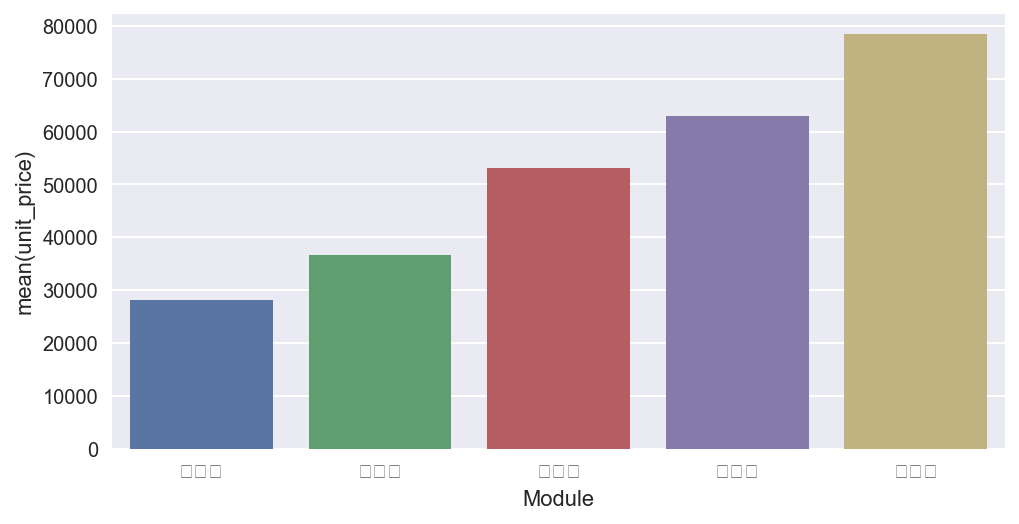

In [150]:
# 环线
all_df.loc[all_df[all_df.Module=='所有'].index,'Module']='内环内'
sorted_module=all_df[['unit_price','Module']].groupby('Module').median().sort_values('unit_price')
print(sorted_module)
sns.barplot(x=sorted_module.index,y='unit_price',data=sorted_module)

In [151]:
# id映射
i=pd.Series(range(0,sorted_module.shape[0]),index=sorted_module.index)
i.to_dict()

{'郊环外': 0, '外郊环': 1, '中外环': 2, '内中环': 3, '内环内': 4}

In [152]:
all_df.Module=all_df.Module.map(i.to_dict())

In [54]:
# 板块均价排序
all_df.groupby(['area','Plate'],as_index=False)['unit_price'].agg({'mean_price':'mean'}).sort_values('mean_price',ascending=False)

,area,Plate,mean_price
168,黄浦,徐汇中心,117271.322222
170,黄浦,淮海中路,113062.527151
165,静安,淮海中路,103209.304348
161,静安,徐汇中心,101428.700000
158,静安,南京西路,101109.637215
164,静安,江宁路,99798.500585
172,黄浦,黄浦滨江,92995.904132
99,浦东,联洋,92594.843326
166,黄浦,人民广场,90585.808543
39,徐汇,徐汇滨江,89789.745430


* 楼层因素

In [153]:
all_df[['all_floor','floor']].describe()

,all_floor,floor
count,4.606175e+06,4.606175e+06
mean,1.313887e+01,6.948954e+00
std,9.751048e+00,6.997631e+00
min,1.000000e+00,-3.000000e+00
25%,6.000000e+00,2.000000e+00
50%,1.100000e+01,5.000000e+00
75%,1.800000e+01,9.000000e+00
max,9.000000e+01,6.300000e+01


In [10]:
# 楼层映射
floor_map=lambda x:list(pd.cut(x,[0,3,6,9,np.inf],labels=['低层','多层','小高层','高层']))
all_df.loc[all_df.floor<0,'floor']=np.nan
# 分段映射
all_df['floor_section']=floor_map(all_df.floor)

# 统计
all_df.groupby('floor_section',as_index=False)['floor_section'].agg({'count':'count'})

,floor_section,count
0,低层,1831037
1,多层,1115099
2,小高层,517490
3,高层,1122243


* 朝向因素

In [ ]:
all_df.shore.unique()

In [ ]:
# 暂无为缺省字段
all_df.shore.replace({'暂无数据':'暂无','      ':'暂无','':'暂无'},inplace=True)
all_df.shore.unique()

In [ ]:
sorted_shore=all_df[['unit_price','shore']].groupby('shore').mean().sort_values('unit_price')
print(sorted_shore)
sns.barplot(x=sorted_shore.index,y='unit_price',data=sorted_shore)

In [ ]:
i=pd.Series(range(0,sorted_shore.shape[0]),index=sorted_shore.index)
i.to_dict()

In [ ]:
all_df.shore=all_df.shore.map(i.to_dict())

* 房屋类型

In [155]:
all_df.house_type.unique()

array(['公寓', '别墅洋房', '商铺', '办公楼', '里弄房', '其它'], dtype=object)

In [156]:
# 统计计数
all_df.house_type.value_counts()

公寓      4499706
别墅洋房      91424
商铺        14632
其它          252
办公楼         124
里弄房          37
Name: house_type, dtype: int64

In [157]:
all_df.loc[all_df[(all_df.house_type=='其它') | (all_df.house_type=='工厂')].index,'house_type']='公寓'
all_df.house_type.unique()

array(['公寓', '别墅洋房', '商铺', '办公楼', '里弄房'], dtype=object)

In [158]:
sorted_house_type=all_df[['house_type','unit_price']].groupby('house_type').median().sort_values('unit_price')
sorted_house_type

,unit_price
house_type,
里弄房,30425.0
办公楼,37139.0
别墅洋房,41703.0
公寓,52223.0
商铺,63572.0


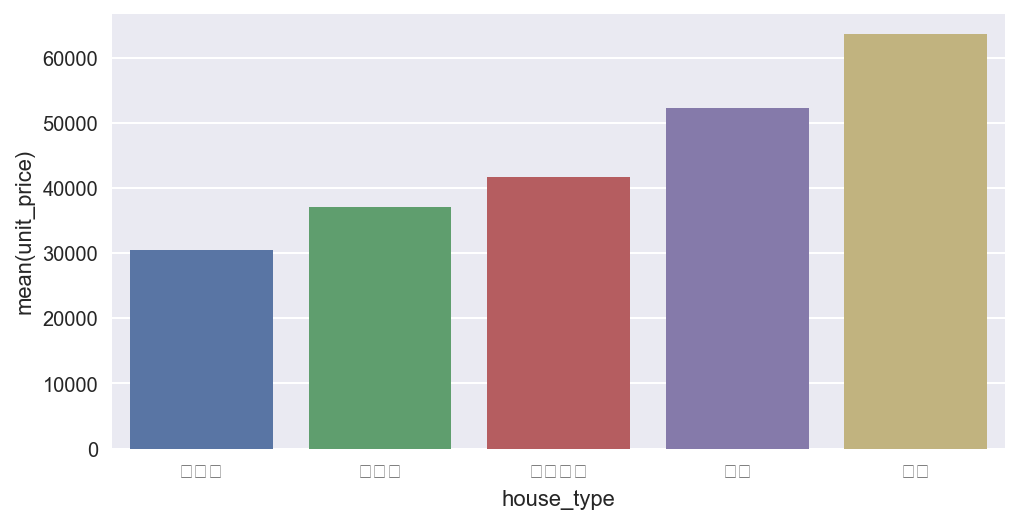

In [160]:
sns.barplot(x=sorted_house_type.index,y='unit_price',data=sorted_house_type)

In [162]:
i=pd.Series(range(0,sorted_house_type.shape[0]),index=sorted_house_type.index)
i.to_dict()

{'里弄房': 0, '办公楼': 1, '别墅洋房': 2, '公寓': 3, '商铺': 4}

In [163]:
all_df.house_type=all_df.house_type.map(i.to_dict())

* 装修情况

In [ ]:
all_df.fitment.unique()

In [ ]:
# 缺省字段填充
default_fit='暂无'
all_df.fitment.replace({'':default_fit,'暂无数据':default_fit,'豪华装':'豪装','其他':default_fit},inplace=True)
all_df.fitment=all_df.fitment.apply(lambda x:x.strip('修'))
all_df.fitment.unique()

In [ ]:
sorted_fitment=all_df[['fitment','unit_price']].groupby('fitment').median().sort_values('unit_price')
print(sorted_fitment)
sns.barplot(x=sorted_fitment.index,y='unit_price',data=sorted_fitment)

In [ ]:
i=pd.Series(range(0,sorted_fitment.shape[0]),index=sorted_fitment.index)
i.to_dict()

In [ ]:
all_df.fitment=all_df.fitment.map(i.to_dict())

* 房型

In [ ]:
import re

# 正则提取房型数据
r=re.compile('室|厅|厨|卫')
l=[map(int,r.split(i)[:-1]) for i in all_df.room_type]
room_type_df=pd.DataFrame(l,index=all_df.index,columns=['室','厅','厨','卫'])

In [ ]:
from sklearn.preprocessing import Imputer

# 中位数填补
# imp = Imputer(missing_values='NaN', strategy='median', axis=0) 
# room_type_df[['室','厅','厨','卫']]=imp.fit_transform(room_type_df[['室','厅','厨','卫']])

# 零填补
# room_type_df.fillna(0)
# room_type_df.describe()

In [ ]:
all_df=pd.concat((all_df,room_type_df),axis=1)
all_df.head()

* 时间

In [164]:
sorted(all_df.time.unique())

['0000-00-00',
 '1864-01-01',
 '1886-01-01',
 '1888-01-01',
 '1889-01-01',
 '1898-01-01',
 '1899-01-01',
 '1900-01-01',
 '1900/1/1',
 '1903-01-01',
 '1903/1/1',
 '1905-01-01',
 '1906-01-01',
 '1910-01-01',
 '1911-01-01',
 '1912-01-01',
 '1912/1/1',
 '1914-01-01',
 '1917-01-01',
 '1918-01-01',
 '1918/1/1',
 '1919-01-01',
 '1920-01-01',
 '1920/1/1',
 '1921-01-01',
 '1921/1/1',
 '1922-01-01',
 '1922/1/1',
 '1923-01-01',
 '1923/1/1',
 '1924-01-01',
 '1924/1/1',
 '1925-01-01',
 '1926-01-01',
 '1926/1/1',
 '1927-01-01',
 '1927/1/1',
 '1928-01-01',
 '1928/1/1',
 '1929-01-01',
 '1930-01-01',
 '1930/1/1',
 '1931-01-01',
 '1931/1/1',
 '1932-01-01',
 '1932/1/1',
 '1933-01-01',
 '1933/1/1',
 '1934-01-01',
 '1934/1/1',
 '1935-01-01',
 '1935/1/1',
 '1936-01-01',
 '1936/1/1',
 '1937-01-01',
 '1937/1/1',
 '1938-01-01',
 '1939-01-01',
 '1939/1/1',
 '1940-01-01',
 '1940/1/1',
 '1941-01-01',
 '1941/1/1',
 '1942-01-01',
 '1942/1/1',
 '1943-01-01',
 '1943/1/1',
 '1944-01-01',
 '1945-01-01',
 '1945/1/1',
 '

In [165]:
def time_map(time):
    if type(time)==str:
        split_char='/' if '/' in time else '-'
        return int(time.split(split_char)[0])
    return None

all_df.time=all_df.time.apply(lambda x:time_map(x)).astype(int)
all_df.time=all_df.time.apply(lambda x:min(2018-x,100) if 0<x<=2018 else None)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
 <a list of 101 Text xticklabel objects>)

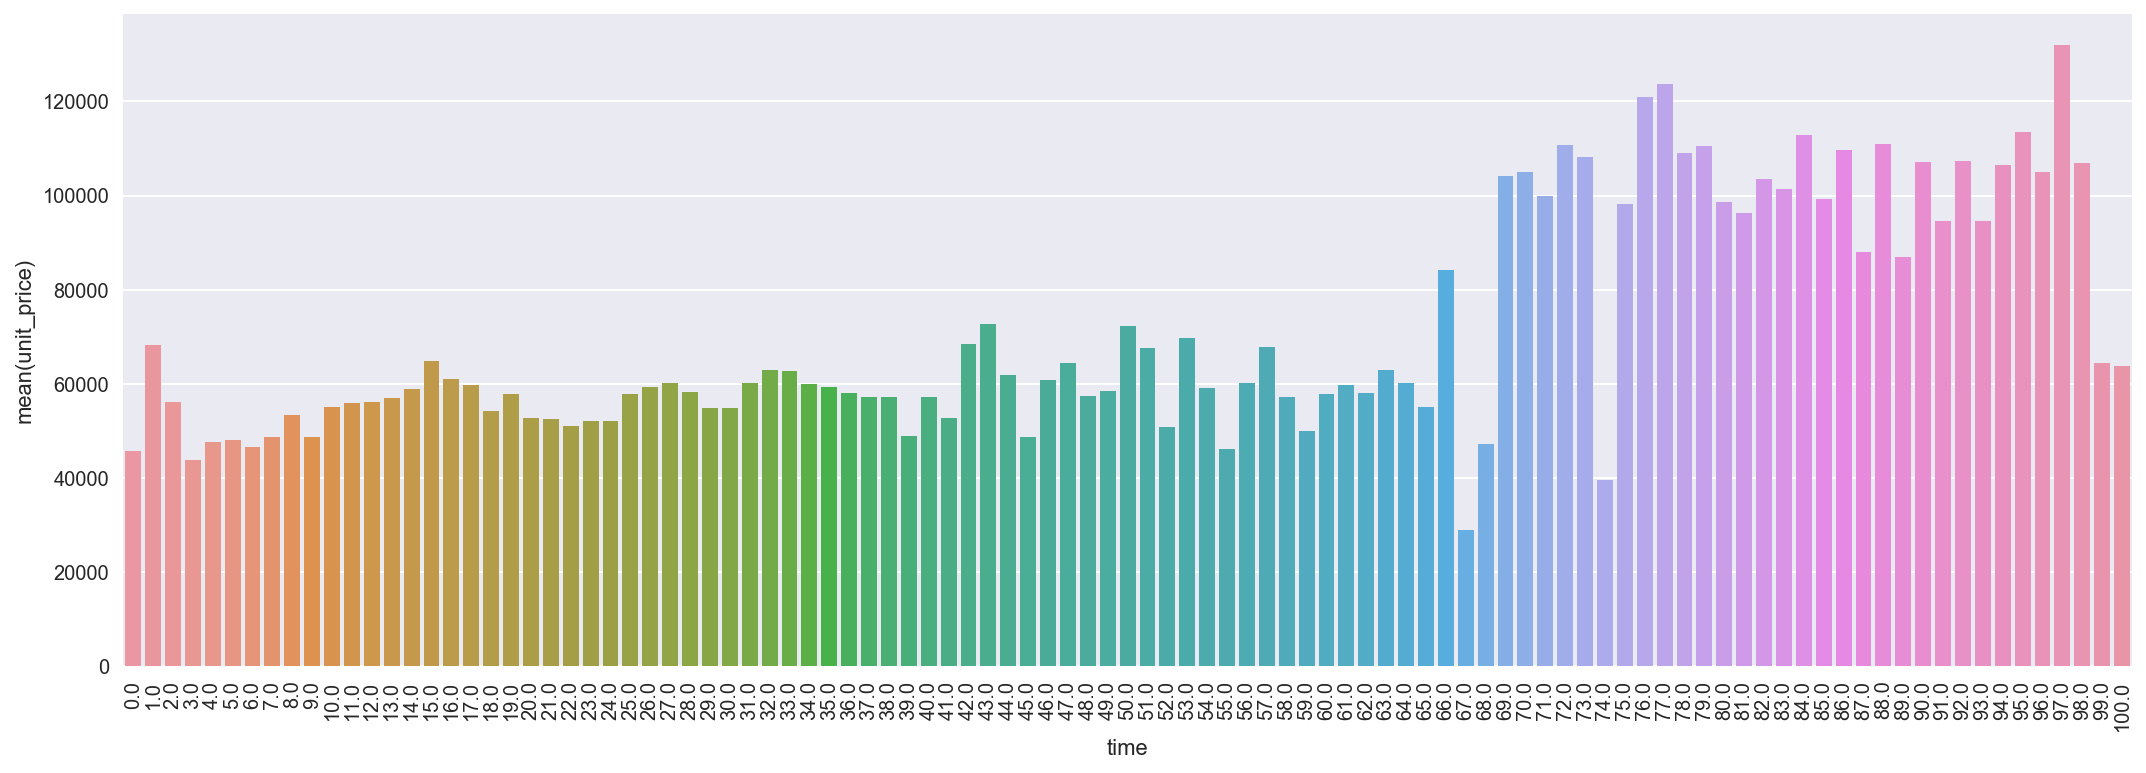

In [166]:
# 房价与单价关系
time_unit_price=all_df[['unit_price','time']].groupby('time').mean()
sns.set({'figure.figsize':(18,6)})
sns.barplot(x=time_unit_price.index,y='unit_price',data=time_unit_price)
plt.xticks(rotation=90)

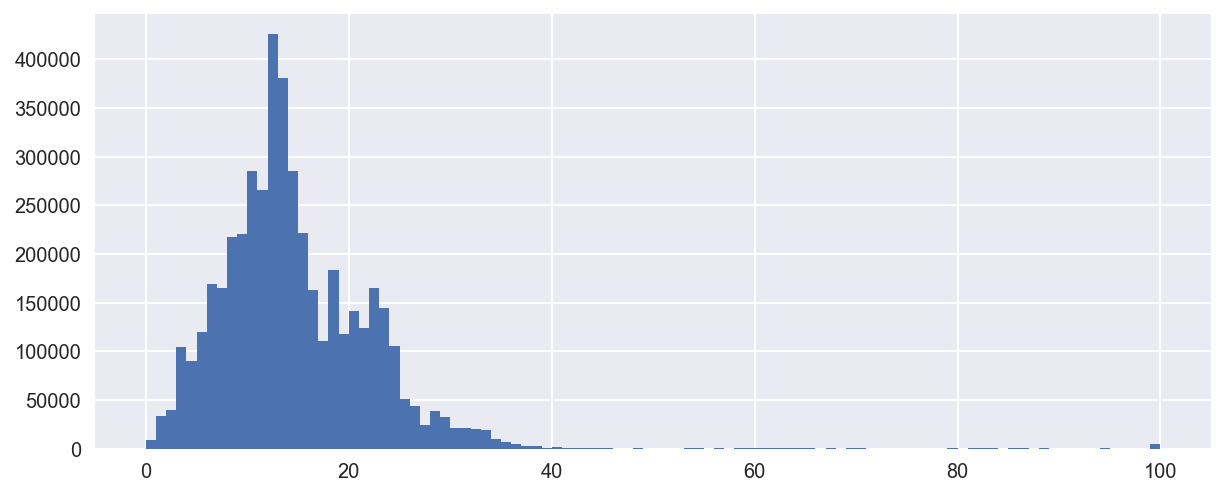

In [167]:
# 房龄分布
sns.set({'figure.figsize':(10,4)})
all_df.time.hist(bins=100)

* 经纬度

In [168]:
def make_coordinates(data):
    coors=[]
    for i in tqdm(data):
        if type(i)==str and i!='公寓' and i!='商业' and i!='其它':
            coors.append(i.split(','))
        else:
            coors.append([None,None])
    coors=pd.DataFrame(coors,columns=['loc_x','loc_y'])
    # coors=pd.DataFrame([coor.split(',') for coor in all_df.Coordinates],columns=['loc_x','loc_y'],index=all_df.index)
    coors=coors.astype(float)
    return coors

coors=make_coordinates(all_df.Coordinates.values)

100%|██████████| 4606175/4606175 [00:10<00:00, 424394.19it/s]


In [169]:
all_df.index=coors.index
all_df=pd.concat((all_df,coors),axis=1).drop('Coordinates',axis=1)
all_df.head()

,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,...,time,Source,house_trait,month,NewDiskID,Plate,Module,floor_section,loc_x,loc_y
0,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,12815,北蔡,2,多层,121.535670,31.190761
1,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,14262,北蔡,3,多层,121.548943,31.183899
2,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,14307,北蔡,3,多层,121.515610,31.178422
3,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,14579,北蔡,3,多层,121.539710,31.188601
4,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,15073,北蔡,3,多层,121.515610,31.178422


In [170]:
# 缓存特征矩阵
all_df=all_df[all_df.unit_price.notnull()]
all_df.to_hdf('./cache/feats.hdf','data')

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['area', 'address', 'name', 'room_type', 'shore', 'fitment', 'Source', 'house_trait', 'Plate', 'floor_section']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [171]:
print('共有%d条训练数据'%all_df.shape[0])

共有4606175条训练数据


* 处理测试集

In [8]:
all_df=pd.read_hdf('./cache/feats_2017-05-2018-04.hdf','data')
print(all_df.shape)
all_df.head()

(4606175, 22)


,area,address,name,price,unit_price,acreage,room_type,all_floor,floor,shore,...,time,Source,house_trait,month,NewDiskID,Plate,Module,floor_section,loc_x,loc_y
0,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,12815,北蔡,2,多层,121.535670,31.190761
1,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,14262,北蔡,3,多层,121.548943,31.183899
2,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,14307,北蔡,3,多层,121.515610,31.178422
3,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,14579,北蔡,3,多层,121.539710,31.188601
4,浦东,华绣路179弄,大华锦绣华城,3500000.0,62500.0,56.0,1室1厅1厨1卫,18.0,6.0,南北,...,10.0,房天下,普通住宅,0,15073,北蔡,3,多层,121.515610,31.178422


In [9]:
# 楼盘基价
x_train=all_df[['area','Plate','Module','time','loc_x','loc_y','unit_price','NewDiskID']]
print(x_train.shape)
x_train.head()

(4606175, 8)


,area,Plate,Module,time,loc_x,loc_y,unit_price,NewDiskID
0,浦东,北蔡,2,10.0,121.535670,31.190761,62500.0,12815
1,浦东,北蔡,3,10.0,121.548943,31.183899,62500.0,14262
2,浦东,北蔡,3,10.0,121.515610,31.178422,62500.0,14307
3,浦东,北蔡,3,10.0,121.539710,31.188601,62500.0,14579
4,浦东,北蔡,3,10.0,121.515610,31.178422,62500.0,15073


In [28]:
# 楼盘基价
property_df=pd.read_csv(property_path,usecols=['PropertyID','Area','Plate','Module'])
newdisk_df=pd.read_csv(newdisk_path,
                       usecols=['NewDiskID','SubmittedDate','PropertyID','Coordinates','NewDiskName','NewDiskType'])
newdisk_df.SubmittedDate=newdisk_df.SubmittedDate.apply(time_map)
newdisk_df['time']=newdisk_df.SubmittedDate.apply(lambda x:min(2018-x,100) if 0<x<=2018 else None)

x_test=pd.merge(newdisk_df,property_df,on=['PropertyID'],how='left')
coors=make_coordinates(x_test.Coordinates.values)
x_test.drop(['PropertyID','Coordinates','SubmittedDate','NewDiskType'],axis=1,inplace=True)
x_test.index=coors.index
x_test=pd.concat((x_test,coors),axis=1)
x_test.rename(columns={'Area':'area','NewDiskName':'name'},inplace=True)
print(x_test.shape)
x_test.head()

100%|██████████| 17861/17861 [00:00<00:00, 554843.86it/s]

(17861, 8)


,NewDiskID,name,time,area,Plate,Module,loc_x,loc_y
0,1,海伦国际大厦,6.0,虹口,四川北路,内环内,121.485939,31.268556
1,2,和源大楼,8.0,静安,大宁,内中环,121.474174,31.271113
2,3,财富中心,18.0,静安,不夜城,内环内,121.469795,31.259057
3,4,科创动力,18.0,徐汇,田林,内中环,121.424125,31.181238
4,5,绿地伯顿商务广场,9.0,松江,松江新城,外郊环,121.253276,31.022715


In [29]:
# 楼盘基价
y_train=x_train.unit_price
mid_price=x_train[['NewDiskID','unit_price']].groupby('NewDiskID',as_index=False)['unit_price'].agg({'mid':'median'})
x_train=pd.merge(x_train,mid_price,on='NewDiskID',how='left')
x_test=pd.merge(x_test,mid_price,on='NewDiskID',how='left')

x_train.loc[x_train[x_train.Module=='所有'].index,'Module']='内环内'
x_test.loc[x_test[x_test.Module=='所有'].index,'Module']='内环内'
sorted_module=x_train[['unit_price','Module']].groupby('Module').mean().sort_values('unit_price')
i=pd.Series(range(0,sorted_module.shape[0]),index=sorted_module.index)
x_train.Module=x_train.Module.map(i.to_dict())
x_test.Module=x_test.Module.map(i.to_dict())

# 将离散型变量转换成整型，用于lgb训练
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder() # 小板块
x_train.area=encoder.fit_transform(x_train.area)
x_test.area=encoder.transform(x_test.area)
x_train.Plate=encoder.fit_transform(x_train.Plate)
x_test.Plate=encoder.fit_transform(x_test.Plate)

x_train.drop(['NewDiskID','unit_price'],axis=1,inplace=True)

# def add_geo(df):
#     geo=[]
#     for i in tqdm(df[['loc_y','loc_x']].values):
#         geo.append(encode(i[0],i[1],6))
#     df['geo']=[i[:-1] for i in geo]
# x_train=add_geo(x_train)
# x_test=add_geo(x_test)

In [34]:
# 单套价格
test_df=pd.read_excel('../../数据/评估师数据/5月份.xlsx')
test_df.reset_index(inplace=True)
print('5月份数据量:%d'%test_df.shape[0])
test_df.rename(columns={'楼盘名称':'name',
                        '房屋类型':'house_type',
                        '竣工年份':'time',
                        '总楼层数':'all_floor',
                        '所属层':'floor',
                        '建筑面积(m2)':'acreage',
                        '楼盘编号':'NewDiskID',
                        '项目名称':'address'},inplace=True)
test_df.head()
# test_df.name=test_df.name.apply(name_filter)

5月份数据量:971


,index,address,house_type,time,all_floor,floor,acreage,NewDiskID,name
0,0,徐汇区宛南三村1号502室,住宅,1985,6.0,5.0,35.49,2744,宛南三村
1,1,闵行区七莘路2938弄24号403室,住宅,1996,6.0,4.0,48.18,5742,宝隆新村
2,2,闵行区青年路246号203室,住宅,1980,6.0,2.0,34.75,0,NaN
3,3,闵行区莘朱路863弄8号203室,住宅,1998,6.0,2.0,69.58,6029,高兴花园
4,4,虹口区虹关路323弄11号1903室,住宅,2014,30.0,19.0,139.32,19879,瑞虹新城六号地块


In [13]:
# 单套价格
def make_train_test_set():
    """构造用于模型训练的训练集和测试集"""
    # 训练集
    x_train=all_df[['acreage','all_floor','floor','time','NewDiskID','area','Plate','Module','floor_section','loc_x','loc_y']]
    y_train=all_df.unit_price
    # 计算小区房价中位数
    med_price=pd.concat((x_train.NewDiskID,y_train),axis=1)
    med_price=med_price.groupby('NewDiskID',as_index=False)['unit_price'].agg({'median':'median'})
    x_train=pd.merge(x_train,med_price,on='NewDiskID',how='left')
    # 计算经纬度geohash信息
#     geo=[]
#     for i in tqdm(x_train[['loc_y','loc_x']].values):
#         geo.append(encode(i[0],i[1],6))
#     x_train['geo']=[i[:-1] for i in geo]
    # 测试集
    x_test=test_df.drop(['项目名称','name','house_type'],axis=1)
    x_test=pd.merge(x_test,x_train.drop(['time','acreage','floor','all_floor'],axis=1),on='NewDiskID',how='inner')
    x_test['floor_section']=floor_map(x_test.floor)
    x_test['time']=x_test.time.apply(lambda x:min(2018-x,100) if 0<x<=2018 else None)
#     y_test=x_test.unit_price
#     x_test.drop('unit_price',axis=1,inplace=True)
    return x_train,y_train,x_test,None

In [20]:
# 单套价格
x_train,y_train,x_test,y_test=make_train_test_set()

# 将离散型变量转换成整型，用于lgb训练
from sklearn.preprocessing import LabelEncoder

area_le=LabelEncoder() # 小区名
plate_le=LabelEncoder() # 小板块
# geo_le=LabelEncoder() # 经纬度

x_train.area=area_le.fit_transform(x_train.area)
x_test.area=area_le.transform(x_test.area)

x_train.Plate=plate_le.fit_transform(x_train.Plate)
x_test.Plate=plate_le.transform(x_test.Plate)

# x_train.geo=geo_le.fit_transform(x_train.geo)
# x_test.geo=geo_le.transform(x_test.geo)

section_map={'低层':0,'小高层':1,'多层':2,'高层':3}
x_train.floor_section=x_train.floor_section.replace(section_map)
x_test.floor_section=x_test.floor_section.replace(section_map)

x_train.drop('NewDiskID',inplace=True,axis=1)
x_test.drop('NewDiskID',inplace=True,axis=1)

In [248]:
# 分割训练/验证集
x1,x2,y1,y2=train_test_split(x_train,y_train,train_size=0.9,random_state=0)

# 缩放标签数据
# price_zoom=10000
# y1/=price_zoom
# y2/=price_zoom

# 删除重要性较低的特征
# x1.drop(['house_type','Module','floor_section'],axis=1,inplace=True)
# x2.drop(['house_type','Module','floor_section'],axis=1,inplace=True)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## 模型训练

* LightGBM

In [22]:
%%time

params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate':0.2,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'max_depth': 14,
    'num_leaves':220,
    'bagging_freq':5,
    'min_data_in_leaf':10,
    'min_gain_to_split':0,
    'lambda_l1':1,
    'lambda_l2':1,
    'verbose':0,
}

val_loss=[]

def eval_error(pred, df):
    """自定义评价函数"""
    score = mean_squared_error(df.get_label(),pred)
    val_loss.append(score)
    return ('mse',score,False)

# lgb_train = lgb.Dataset(x1,y1,categorical_feature=['floor_section','Plate','Module'])
# lgb_val=lgb.Dataset(x2,y2,reference=lgb_train)
# # # gbm = lgb.cv(params,lgb_train,num_boost_round=3000,early_stopping_rounds=20,feval=eval_error,nfold=3)
# gbm = lgb.train(params,lgb_train,num_boost_round=2000,valid_sets=lgb_val,early_stopping_rounds=15,feval=eval_error)

lgb_train = lgb.Dataset(x_train,y_train,categorical_feature=['area','Plate','Module','floor_section'])
gbm = lgb.train(params,lgb_train,num_boost_round=750)

CPU times: user 12min 59s, sys: 1min 16s, total: 14min 15s
Wall time: 3min 36s


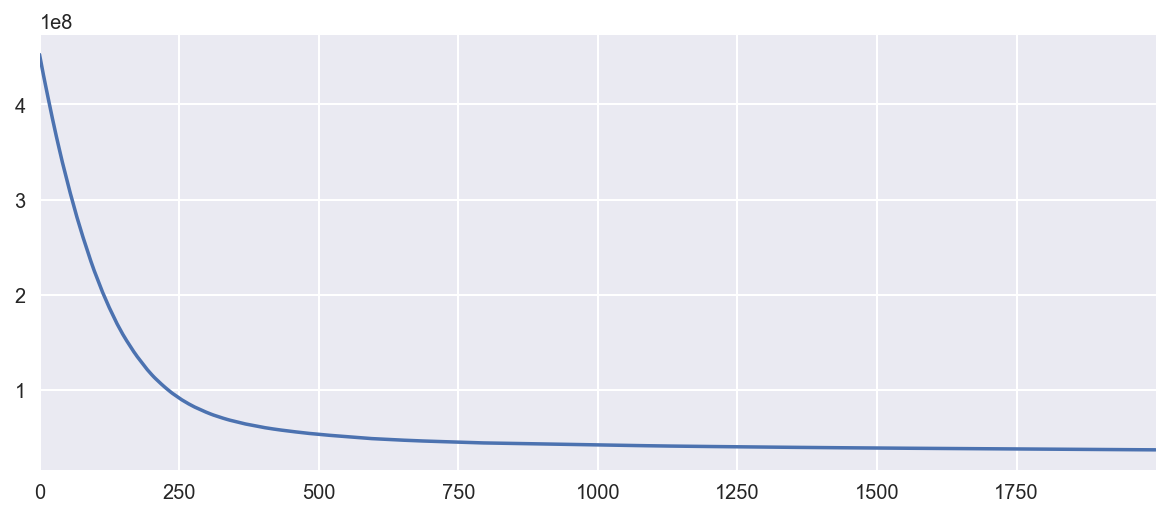

In [253]:
# 绘制测试集损失函数曲线
pd.Series(val_loss).plot()

In [256]:
# 保存模型
gbm.save_model('./cache/model.txt')

In [ ]:
# 加载模型
gbm=lgb.Booster(model_file='./cache/model.txt')

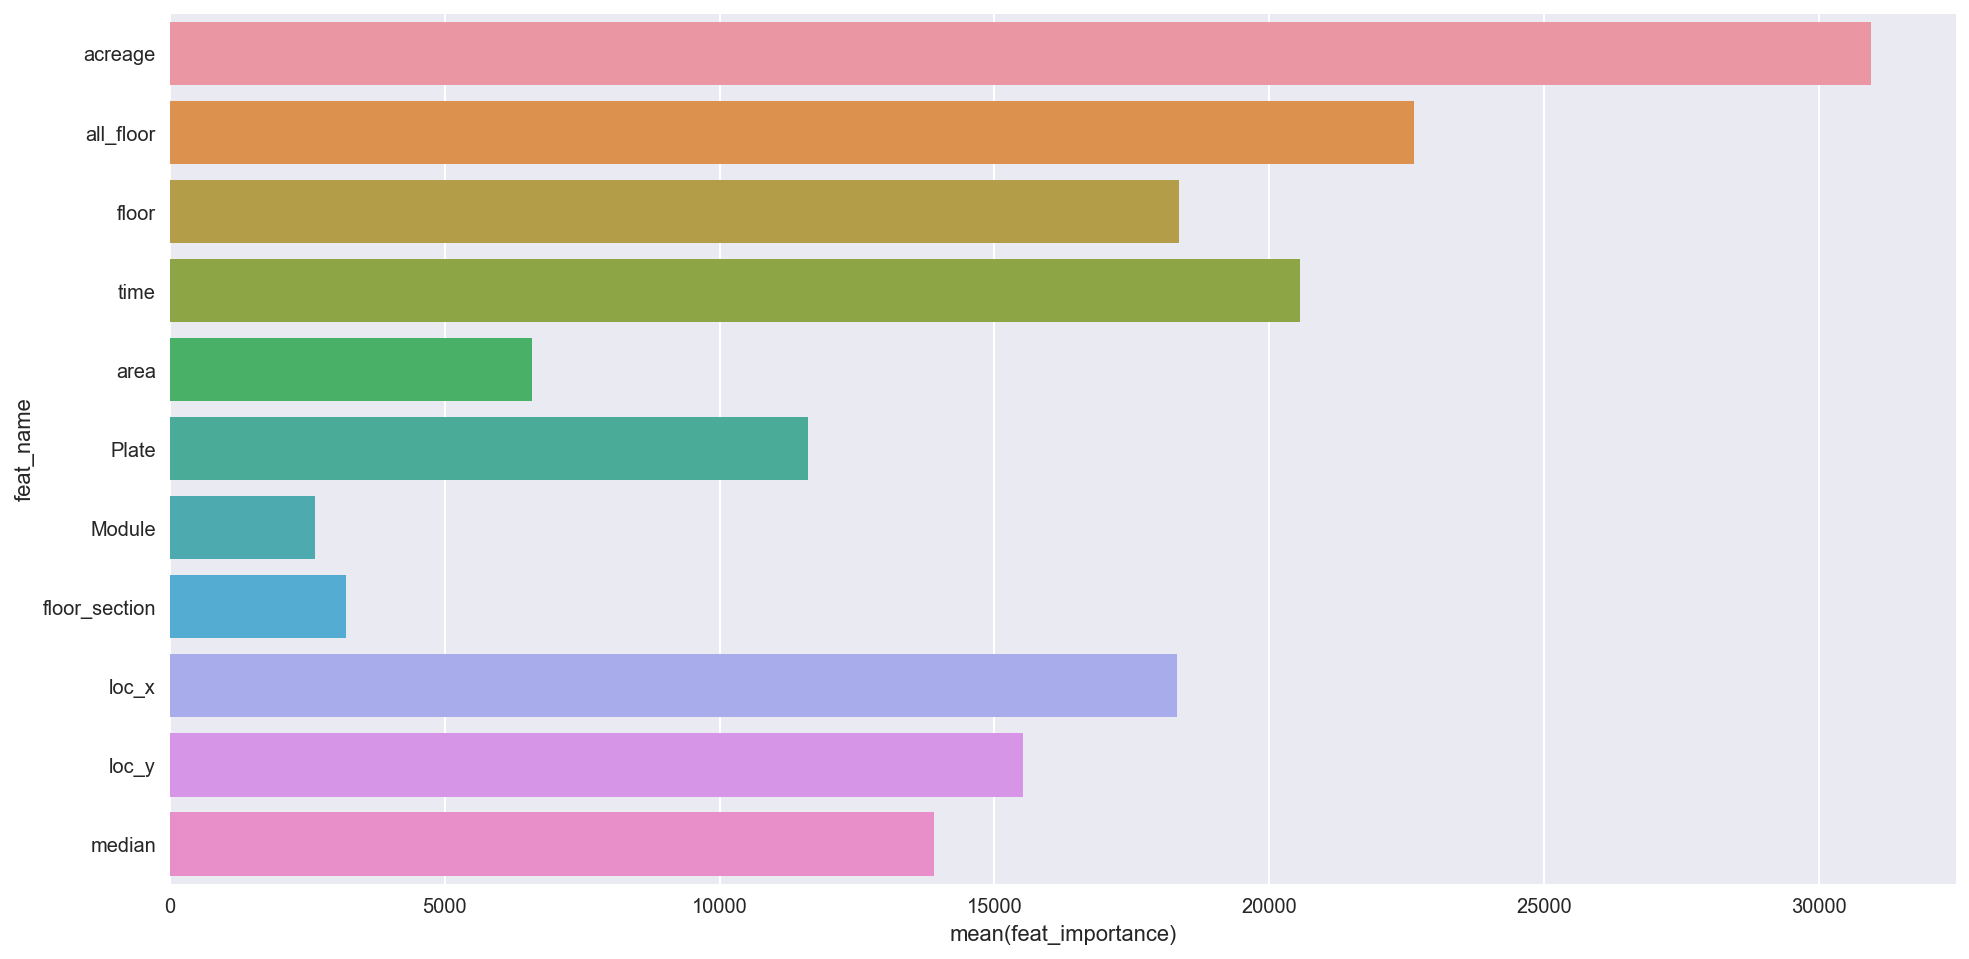

In [23]:
# 特征重要程度
sns.set({'figure.figsize':(16,8)})
sns.barplot(data=pd.DataFrame({'feat_name':x_train.columns,'feat_importance':gbm.feature_importance()}),x='feat_importance',y='feat_name')

In [ ]:
# # 测试误差
# y_pred_test=gbm.predict(x_test)
# mean_squared_error(y_pred_test,y_test)

In [ ]:
# # 测试误差分布图
# df_test=pd.DataFrame({'pred':y_pred_test,'true':y_test})
# df_test['diff']=np.abs(df_test.pred-df_test.true)
# sns.set({'figure.figsize':(10,5)})
# sns.boxplot(df_test['diff'])

In [ ]:
# # 误差百分比统计
# df_test['ratio']=(df_test['diff']/df_test.true)*100
# pd.cut(df_test.ratio,[0,10,15,20,30,40,100]).value_counts()/df_test.shape[0]

In [24]:
y_pred=gbm.predict(x_test[x_train.columns])
prices=pd.DataFrame({'index':x_test['index'],'price':y_pred})

In [25]:
ans_df=prices.groupby('index',as_index=False)['price'].median()
ans_df=pd.merge(test_df,ans_df,on='index',how='left')
ans_df.drop('index',axis=1,inplace=True)
ans_df.to_csv('result1.csv',index=False)
ans_df

,项目名称,house_type,time,all_floor,floor,acreage,NewDiskID,name,price
0,徐汇区宛南三村1号502室,住宅,1985,6.0,5.0,35.49,2744,宛南三村,66536.282318
1,闵行区七莘路2938弄24号403室,住宅,1996,6.0,4.0,48.18,5742,宝隆新村,57693.689653
2,闵行区青年路246号203室,住宅,1980,6.0,2.0,34.75,0,NaN,NaN
3,闵行区莘朱路863弄8号203室,住宅,1998,6.0,2.0,69.58,6029,高兴花园,52112.661122
4,虹口区虹关路323弄11号1903室,住宅,2014,30.0,19.0,139.32,19879,瑞虹新城六号地块,NaN
5,松江区文翔路3588弄9号304（复式）室,住宅,2010,5.0,3.0,181.59,9884,上尚缘,38157.210276
6,浦东新区灵山路708弄3号303室,住宅,2000,11.0,3.0,129.43,11556,申立苑,77138.747406
7,浦东新区锦绣路888弄25号2201室,住宅,2002,24.0,22.0,131.28,10833,御景园,85340.224250
8,浦东新区潍坊西路2弄16号6201室,住宅,2006,55.0,NaN,283.32,14096,世茂滨江花园（公寓2004）,82370.389663
9,松江区新桥镇明中路666弄65号全幢,花园住宅,2009,2.0,1.0,676.74,17284,乔爱花园,NaN


In [30]:
# 覆盖度
ans_df.price.notnull().sum()/ans_df.shape[0]

0.8383110195674562

In [ ]:
preds=gbm.predict(x_test[x_train.columns])
result=pd.DataFrame({'NewDiskID':x_test.NewDiskID,'楼盘':x_test.name,'单价':preds,'Mark':x_test.mid.notnull()*1})
result=result[['NewDiskID','楼盘','单价','Mark']]
result.to_csv('price.csv',index=False)
result

In [39]:
ans=pd.read_csv('../../数据/3月基价.csv')
ans=ans[ans['公寓价格']!=0]
merge=pd.merge(ans,result,on='NewDiskID',how='inner')

In [40]:
np.sqrt(mean_squared_error(merge['公寓价格'],merge['单价']))

17853.071520661968

In [54]:
all_df[all_df.name=='和源大楼'].unit_price.median()

25753.0

In [70]:
np.sqrt(mean_squared_error(ans2['单价'],result['单价']))

3050.027113513042